In this notebook, we'll simply compare all features with the survival rate and try to find the ones that actually have an effect. Essentially, we're trying to find features that will "cause" survival, rather than just "correlate to" survival.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns # data visualization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
train_data.rename(columns={'SibSp':'SiblingsSpouses', 'Parch':'ParentsChildren'}, inplace = True)
test_data.rename(columns={'SibSp':'SiblingsSpouses', 'Parch':'ParentsChildren'}, inplace = True)
test_columns = test_data.columns
train_columns = train_data.columns

We try to find rows with a NaN for every column. This would give missing values for a feature that we can try to approximate.

In [2]:
print ("\nNaN rows per column in training data\n")
for col in train_columns:
    print (col, ": ", train_data[train_data[col].isnull()].shape[0])
    
print ("\nNaN rows per column in test data\n")
for col in test_columns:
    print (col, ": ", test_data[test_data[col].isnull()].shape[0])


NaN rows per column in training data

PassengerId :  0
Survived :  0
Pclass :  0
Name :  0
Sex :  0
Age :  177
SiblingsSpouses :  0
ParentsChildren :  0
Ticket :  0
Fare :  0
Cabin :  687
Embarked :  2

NaN rows per column in test data

PassengerId :  0
Pclass :  0
Name :  0
Sex :  0
Age :  86
SiblingsSpouses :  0
ParentsChildren :  0
Ticket :  0
Fare :  1
Cabin :  327
Embarked :  0


A lot of ages are missing; and it's probably likely that age would be a good feature. Let's try to approximate the missing values

We are going to approximate the ages by using median values. We divide the dataset into male and female, and also look at the title in the name. 

Someone with Master in the name is likely to be 18 years or younger. 

Someone with Miss is either younger than 18, or older but un-married. For those older, we look for females who are not traveling with parents or children. It's an approximation, but it should work for our dataset.

We could have also just taken the median per sex and approximate it that way. It shouldn't make a big difference in the accuracy for this particular problem.

In [3]:
temp = train_data[pd.notnull(train_data['Age'])]
maletemp = temp[temp['Sex'] == 'male']
femaletemp = temp[temp['Sex'] == 'female']
youngmisstemp = femaletemp[femaletemp['Name'].str.contains('Miss')]
youngmisstemp = youngmisstemp[youngmisstemp['ParentsChildren'] > 0]
oldmisstemp = femaletemp[femaletemp['Name'].str.contains('Miss')]
oldmisstemp = oldmisstemp[oldmisstemp['ParentsChildren'] == 0]

mastermedian = maletemp[maletemp['Name'].str.contains('Master')]['Age'].median()
mistermedian = maletemp[maletemp['Name'].str.contains('Mr.')]['Age'].median()
mrsmedian = femaletemp[femaletemp['Name'].str.contains('Mrs.')]['Age'].median()
youngmissmedian = youngmisstemp['Age'].median()
oldmissmedian = oldmisstemp['Age'].median()

In [4]:
print("MasterMedian", mastermedian)
print("MisterMedian", mistermedian)
print("MrsMedian", mrsmedian)
print("OldMissMedian", oldmissmedian)
print("YoungMissMedian", youngmissmedian)

MasterMedian 3.5
MisterMedian 30.0
MrsMedian 35.0
OldMissMedian 26.0
YoungMissMedian 9.0


So now we have a decent approximation of the unavailable ages

If male, and name contains Master, use 3.5 

If male, and name contains Mr., use 30

If female, and name contains Mrs., use 35

if female, and name contains Miss, and ParentsChildren>0, use 9

If female, and name contains Miss, and ParentsChildren=0, use 26

In [5]:
mastermask = (train_data['Name'].str.contains('Master')) & (train_data['Sex'] == 'male') & (np.isnan(train_data['Age']))
mrmask = (train_data['Name'].str.contains('Mr.')) & (train_data['Sex'] == 'male') & (np.isnan(train_data['Age']))
mrsmask = (train_data['Name'].str.contains('Mrs.')) & (train_data['Sex'] == 'female') & (np.isnan(train_data['Age']))
youngmissmask = (train_data['Name'].str.contains('Miss')) & (train_data['Sex'] == 'female') & (train_data['ParentsChildren']>0) & (np.isnan(train_data['Age']))
oldmissmask = (train_data['Name'].str.contains('Miss')) & (train_data['Sex'] == 'female') & (train_data['ParentsChildren']==0) & (np.isnan(train_data['Age']))

In [6]:
train_data.loc[mastermask, 'Age'] = 3.5
train_data.loc[mrmask, 'Age'] = 30
train_data.loc[mrsmask, 'Age'] = 35
train_data.loc[youngmissmask, 'Age'] = 9
train_data.loc[oldmissmask, 'Age'] = 26

Let's look at the training data and make sure there are no NaN values for age

In [7]:
print (train_data[pd.isnull(train_data['Age'])])

     PassengerId  Survived  Pclass                       Name   Sex  Age  \
766          767         0       1  Brewe, Dr. Arthur Jackson  male  NaN   

     SiblingsSpouses  ParentsChildren  Ticket  Fare Cabin Embarked  
766                0                0  112379  39.6   NaN        C  


Looks like we have one entry; a Dr. Arthur Jackson Brewe. We can manually set his age to 30.

In [8]:
train_data.loc[train_data['PassengerId'] == 767, 'Age'] = 30
print (train_data[pd.isnull(train_data['Age'])])

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SiblingsSpouses, ParentsChildren, Ticket, Fare, Cabin, Embarked]
Index: []


So now, our training data has no NaN age values. Let's now look at the test set, and do a similar approximation for the missing ages there. As another approximation, we will use the same median values as the ones we used for the training set. Again, we could have simply used median values per sex.

In [9]:
temp = test_data

mastermask = (temp['Name'].str.contains('Master')) & (temp['Sex'] == 'male') & (np.isnan(temp['Age']))
mrmask = (temp['Name'].str.contains('Mr.')) & (temp['Sex'] == 'male') & (np.isnan(temp['Age']))
mrsmask = (temp['Name'].str.contains('Mrs.')) & (temp['Sex'] == 'female') & (np.isnan(temp['Age']))
youngmissmask = (temp['Name'].str.contains('Miss')) & (temp['Sex'] == 'female') & (temp['ParentsChildren']>0) & (np.isnan(temp['Age']))
oldmissmask = (temp['Name'].str.contains('Miss')) & (temp['Sex'] == 'female') & (temp['ParentsChildren']==0) & (np.isnan(temp['Age']))
oldmissmask2 = (temp['Name'].str.contains('Ms.')) & (temp['Sex'] == 'female') & (temp['ParentsChildren']==0) & (np.isnan(temp['Age']))

temp.loc[mastermask, 'Age'] = 3.5
temp.loc[mrmask, 'Age'] = 30
temp.loc[mrsmask, 'Age'] = 35
temp.loc[youngmissmask, 'Age'] = 9
temp.loc[oldmissmask, 'Age'] = 26
temp.loc[oldmissmask2, 'Age'] = 26

In [10]:
print (temp[pd.isnull(temp['Age'])])

Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SiblingsSpouses, ParentsChildren, Ticket, Fare, Cabin, Embarked]
Index: []


So now our test data is also cleaned up for Age. Let's save it in a new variable; temp is too generic.

In [11]:
test_data_clean = temp

Now we will create a few graphs; mapping a few interesting features individually versus survival

In [12]:
print ("Pclass v Survived")

Pclass v Survived


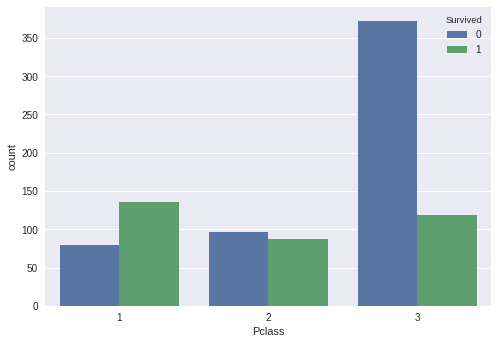

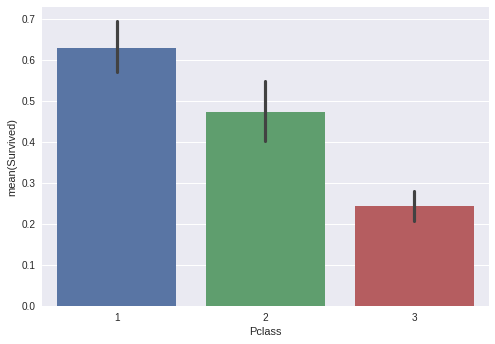

In [13]:
temp = train_data[['Survived','Pclass']]
plt.figure()
sns.countplot(x='Pclass', hue='Survived', data=temp)
plt.figure()
sns.barplot(x='Pclass', y='Survived', data=temp)

In [14]:
print ("Sex v Survived")

Sex v Survived


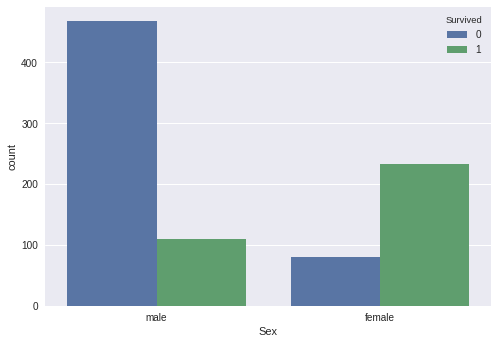

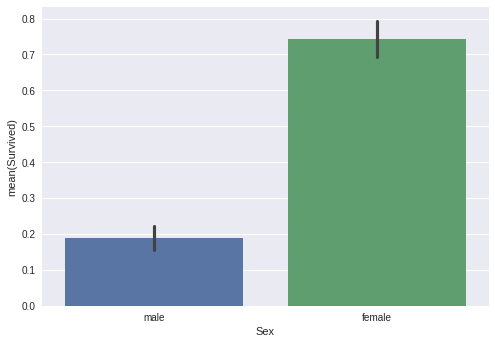

In [15]:
temp = train_data[['Survived','Sex']]
plt.figure()
sns.countplot(x='Sex', hue='Survived', data=temp)
plt.figure()
sns.barplot(x='Sex', y='Survived', data=temp)

In [16]:
print ("Age v Survived")

Age v Survived


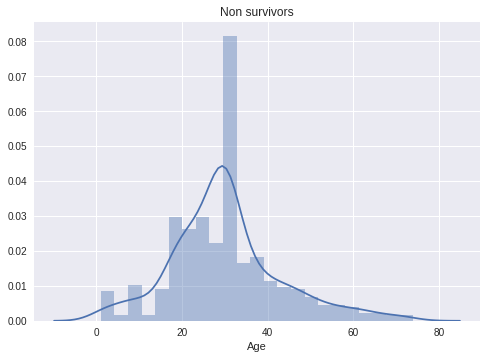

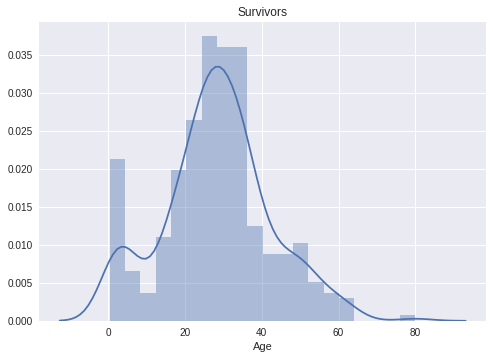

In [17]:
temp = train_data[['Survived','Age']]

plt.figure()
plt.title('Non survivors')
sns.distplot(temp['Age'][(temp['Survived'] == 0)])
plt.figure()
plt.title('Survivors')
sns.distplot(temp['Age'][(temp['Survived'] == 1)])

The histograms didn't really help much. Let's try to separate the sexes, and put the ages in buckets of 10.

/home/mickey/anaconda2/envs/MLPy3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mickey/anaconda2/envs/MLPy3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


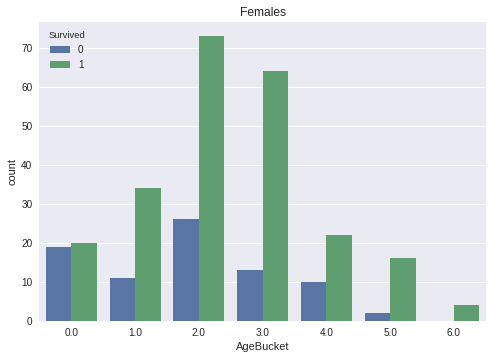

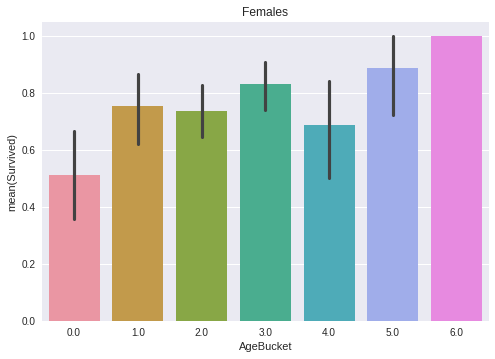

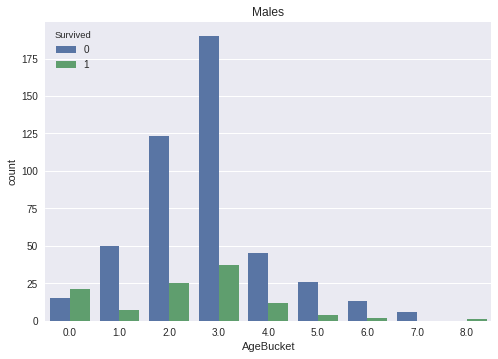

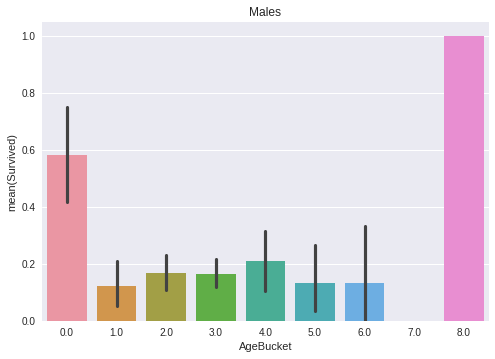

In [18]:
temp = train_data[['Age', 'Survived', 'Sex']]
female_temp = temp[temp['Sex'] == 'female']
male_temp = temp[temp['Sex'] == 'male']

female_temp['AgeBucket'] = female_temp['Age'].apply(lambda x: x//10)
plt.figure()
plt.title('Females')
sns.countplot(x='AgeBucket', hue='Survived', data = female_temp)
plt.figure()
plt.title('Females')
sns.barplot(x='AgeBucket', y='Survived', data = female_temp)

male_temp['AgeBucket'] = male_temp['Age'].apply(lambda x: x//10)
plt.figure()
plt.title('Males')
sns.countplot(x='AgeBucket', hue='Survived', data = male_temp)
plt.figure()
plt.title('Males')
sns.barplot(x='AgeBucket', y='Survived', data = male_temp)

In [19]:
print ("SiblingsSpouses v Survived")

SiblingsSpouses v Survived


Let's modify the data a little; instead of taking number of siblings/spouses, we will only do a binary presence or absence of siblings/spouses

/home/mickey/anaconda2/envs/MLPy3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


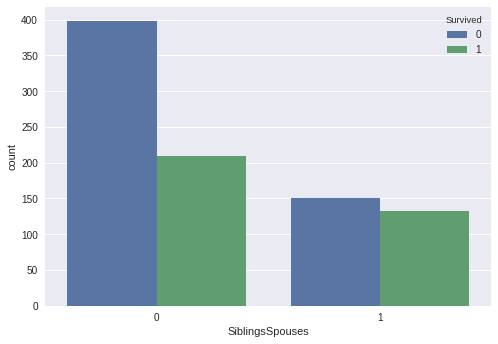

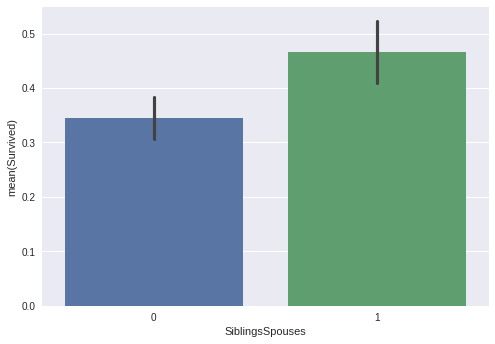

In [20]:
temp = train_data[['Survived','SiblingsSpouses']]
temp['SiblingsSpouses'] = temp['SiblingsSpouses'].apply(lambda x: 1 if x > 0 else 0)

plt.figure()
sns.countplot(x='SiblingsSpouses', hue='Survived', data=temp)
plt.figure()
sns.barplot(x='SiblingsSpouses', y='Survived', data=temp)

In [21]:
print ("ParentsChildren v Survived")

ParentsChildren v Survived


Let's modify the data again; instead of taking total number, we will only do a binary presence or absence

/home/mickey/anaconda2/envs/MLPy3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


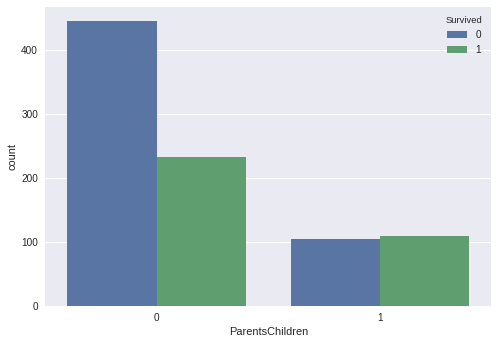

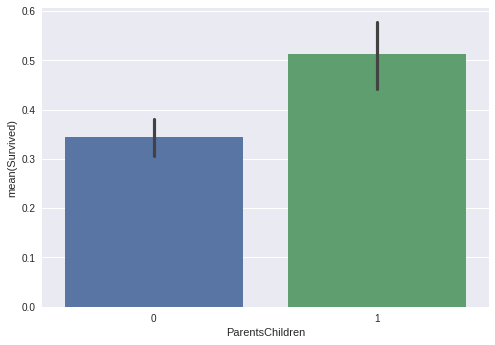

In [22]:
temp = train_data[['Survived','ParentsChildren']]
temp['ParentsChildren'] = temp['ParentsChildren'].apply(lambda x: 1 if x > 0 else 0)

plt.figure()
sns.countplot(x='ParentsChildren', hue='Survived', data=temp)
plt.figure()
sns.barplot(x='ParentsChildren', y='Survived', data=temp)

In [23]:
print ("Embarked v Survived")

Embarked v Survived


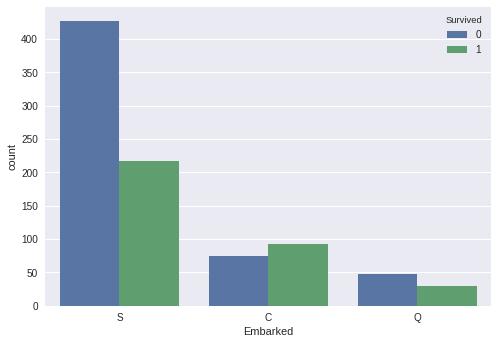

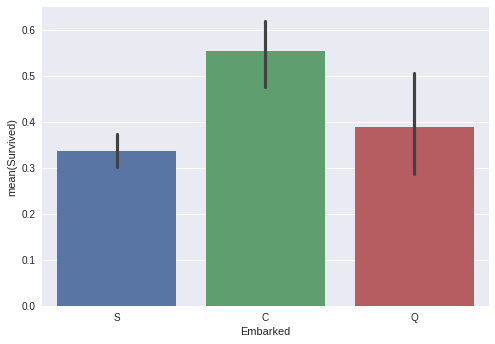

In [24]:
temp = train_data[['Survived','Embarked']]

plt.figure()
sns.countplot(x='Embarked', hue='Survived', data=temp)
plt.figure()
sns.barplot(x='Embarked', y='Survived', data=temp)

There seems to be a high number of non-survivors for people embarking from port S. My guess is there were probably more males from that port. Let's test that hypothesis.

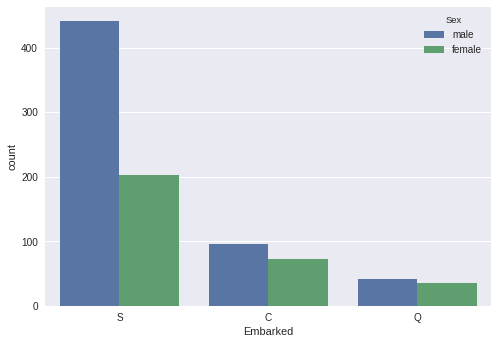

In [25]:
temp = train_data[['Embarked', 'Sex', 'Survived']]
plt.figure()
sns.countplot(x='Embarked', hue = 'Sex', data=temp)

That seems to prove that port of embarkation doesn't really have any effect on survival rates; rather it's the sex of the passenger.

One thing we haven't looked at is the Name column. Let's take a look and see if we can infer anything

In [26]:
temp = train_data[~(train_data['Name'].str.contains('Mr.') | train_data['Name'].str.contains('Master') | \
                  train_data['Name'].str.contains('Mrs.') | train_data['Name'].str.contains('Miss') | \
                  train_data['Name'].str.contains('Ms.'))]
print (temp['Name'])

30                              Uruchurtu, Don. Manuel E
149                    Byles, Rev. Thomas Roussel Davids
150                           Bateman, Rev. Robert James
245                          Minahan, Dr. William Edward
249                        Carter, Rev. Ernest Courtenay
317                                 Moraweck, Dr. Ernest
369                        Aubart, Mme. Leontine Pauline
398                                     Pain, Dr. Alfred
449                       Peuchen, Major. Arthur Godfrey
536                    Butt, Major. Archibald Willingham
626                       Kirkland, Rev. Charles Leonard
632                            Stahelin-Maeglin, Dr. Max
641                                 Sagesser, Mlle. Emma
647                  Simonius-Blumer, Col. Oberst Alfons
660                        Frauenthal, Dr. Henry William
694                                      Weir, Col. John
745                         Crosby, Capt. Edward Gifford
759    Rothes, the Countess. of

Let's see whether these people survived or not. A lot of them are clergymen; a few doctors, captains, and some royalty.

In [27]:
print (temp[temp['Survived'] == 1])

     PassengerId  Survived  Pclass  \
369          370         1       1   
449          450         1       1   
632          633         1       1   
641          642         1       1   
647          648         1       1   
660          661         1       1   
759          760         1       1   
796          797         1       1   

                                                  Name     Sex   Age  \
369                      Aubart, Mme. Leontine Pauline  female  24.0   
449                     Peuchen, Major. Arthur Godfrey    male  52.0   
632                          Stahelin-Maeglin, Dr. Max    male  32.0   
641                               Sagesser, Mlle. Emma  female  24.0   
647                Simonius-Blumer, Col. Oberst Alfons    male  56.0   
660                      Frauenthal, Dr. Henry William    male  50.0   
759  Rothes, the Countess. of (Lucy Noel Martha Dye...  female  33.0   
796                        Leader, Dr. Alice (Farnham)  female  49.0   

     Sib

So there is some correlation between your title and survival. Royalty is a good indicator of survival!

So we will be using the following features:

Sex, Pclass (these are self-explanatory from the graphs. Females, and first class have high survival rates)

Age: for females, the graph didn't really have much going on. But for males, the youngest and oldest have much higher rates of survival

Siblings/Spouses & Parents/Children: Travelling with companions does seem to increase survival odds. Or rather the other way around; travelling alone means higher rates of dying.

Title: We will include title to include the edge cases for royalty.

Port: We will not be using this feature; even though "S" has a high rate of dying, there are also almost twice the number of males at that port. The hidden feature here is just age again.

In [28]:
train_data_features = pd.concat([train_data['Age'], train_data['Sex'], train_data['Pclass'], \
                                 train_data['SiblingsSpouses'], train_data['ParentsChildren'], \
                                train_data['Name']], axis=1)
     
train_data_features['SiblingsSpouses'] = train_data_features['SiblingsSpouses'].apply(lambda x: 1 if x > 0 else 0)
train_data_features['ParentsChildren'] = train_data_features['ParentsChildren'].apply(lambda x: 1 if x > 0 else 0)
train_data_features['Sex'] = train_data_features['Sex'].apply(lambda x: 1 if x =='female' else 0)

train_data_features['Name'] = train_data_features['Name'].apply(lambda x: 0 if ('Mr.' in x or 'Master' in x or 'Mrs.' in x \
                                                                               or 'Miss' in x or 'Ms.' in x) else 1)

Let's start with a very basic decision tree

In [29]:
from sklearn import tree
basic_model = tree.DecisionTreeClassifier()

Let's do a 10-fold cross-validation, and take the average accuracy of our model

In [30]:
from sklearn.model_selection import KFold
splits = 10
kf = KFold(n_splits = splits, shuffle = True)
accuracy = 0
for train_fold, cv_fold in kf.split(train_data_features):
    basic_model.fit(train_data_features.loc[train_fold], train_data.loc[train_fold,'Survived'])
    y_true = train_data.loc[cv_fold, 'Survived']
    accuracy = accuracy + basic_model.score(train_data_features.loc[cv_fold], y_true)

accuracy = accuracy/splits

print ("Basic Decision Tree accuracy: ", accuracy)

Basic Decision Tree accuracy:  0.793508114856


Depending on the shuffle, accuracy varies between 78% and 80%; not bad. Now let's try a more complex model

In [31]:
from sklearn import ensemble
adaboostclassifier = ensemble.AdaBoostClassifier()

In [32]:
splits = 10
kf = KFold(n_splits = splits, shuffle = True)
accuracy = 0
for train_fold, cv_fold in kf.split(train_data_features):    
    adaboostclassifier.fit(train_data_features.loc[train_fold], train_data.loc[train_fold,'Survived'])
    y_true = train_data.loc[cv_fold, 'Survived']
    accuracy = accuracy + adaboostclassifier.score(train_data_features.loc[cv_fold], y_true)
    
accuracy = accuracy/10
print ("Adaboost Decision tree accuracy: ", accuracy)

Adaboost Decision tree accuracy:  0.800237203496


Accuracy is between 80% and 82%; A little better. Let's try another model.

In [33]:
splits = 10
kf = KFold(n_splits = splits, shuffle = True)
randomforestclassifier = ensemble.RandomForestClassifier()
accuracy = 0
for train_fold, cv_fold in kf.split(train_data_features): 
    randomforestclassifier.fit(train_data_features.loc[train_fold], train_data.loc[train_fold,'Survived'])
    y_true = train_data.loc[cv_fold, 'Survived']
    accuracy = accuracy + randomforestclassifier.score(train_data_features.loc[cv_fold], y_true)
    
accuracy = accuracy/10
print ("Random Forests accuracy: ", accuracy)

Random Forests accuracy:  0.78570536829


Not bad; accuracy is between 78% and 80%. At this point, we can probably pick either of the three. Let's try to now work with Adaboost and vary it's parameters.

In [34]:
splits = 10
kf = KFold(n_splits = 10, shuffle = True)
accuracy = 0
max_accuracy = 0
best_estimators = 0
total_estimators = [10,20,30,40,50,60,70,80,90,100]
for estimators in total_estimators:
    adaboostclassifier = ensemble.AdaBoostClassifier(n_estimators=estimators)
    for train_fold, cv_fold in kf.split(train_data_features):    
        adaboostclassifier.fit(train_data_features.loc[train_fold], train_data.loc[train_fold,'Survived'])
        y_true = train_data.loc[cv_fold, 'Survived']
        accuracy = accuracy + adaboostclassifier.score(train_data_features.loc[cv_fold], y_true)    
    accuracy = accuracy/10
    if (accuracy > max_accuracy):
        max_accuracy = accuracy
        best_estimators = estimators


print ("Adaboost Decision tree max accuracy: ", max_accuracy, "at", best_estimators, "estimators.")

Adaboost Decision tree max accuracy:  0.898718609238 at 50 estimators.


Let's do something similar with our simplest model

In [35]:
splits = 10
kf = KFold(n_splits = 10, shuffle = True)
accuracy = 0
max_accuracy = 0
best_depth = 0
depthrange = range(1, train_data_features.shape[1])
for depth in depthrange:
    basic_model = tree.DecisionTreeClassifier(max_depth = depth)
    for train_fold, cv_fold in kf.split(train_data_features):    
        basic_model.fit(train_data_features.loc[train_fold], train_data.loc[train_fold,'Survived'])
        y_true = train_data.loc[cv_fold, 'Survived']
        accuracy = accuracy + basic_model.score(train_data_features.loc[cv_fold], y_true)    
    accuracy = accuracy/10
    if (accuracy > max_accuracy):
        max_accuracy = accuracy
        best_depth = depth
    
print ("Basic Decision tree accuracy: ", max_accuracy, "at", best_depth, "depth.")

Basic Decision tree accuracy:  0.888798114856 at 4 depth.


This is good; 88-90% accuracy at depths of 4 or 5 (depending on the shuffle)

Now let's run the basic model against our test data. We will use a depth of 5.

In [39]:
test_data_clean_features = pd.concat([test_data_clean['Age'], test_data_clean['Sex'], test_data_clean['Pclass'], \
                                 test_data_clean['SiblingsSpouses'], test_data_clean['ParentsChildren'], \
                                test_data_clean['Name']], axis=1)
PID = test_data_clean['PassengerId']

test_data_clean_features['SiblingsSpouses'] = test_data_clean_features['SiblingsSpouses'].apply(lambda x: 1 if x > 0 else 0)
test_data_clean_features['ParentsChildren'] = test_data_clean_features['ParentsChildren'].apply(lambda x: 1 if x > 0 else 0)
test_data_clean_features['Sex'] = test_data_clean_features['Sex'].apply(lambda x: 1 if x =='female' else 0)

test_data_clean_features['Name'] = test_data_clean_features['Name'].apply(lambda x: 0 if ('Mr.' in x or 'Master' in x \
                                                                                          or 'Mrs.' in x or 'Miss' in x \
                                                                                          or 'Ms.' in x) else 1)

In [40]:
adaboostclassifier = ensemble.AdaBoostClassifier(n_estimators=70)
adaboostclassifier.fit(train_data_features, train_data['Survived'])
test_predictions = adaboostclassifier.predict(test_data_clean_features)
submission = pd.DataFrame({"PassengerId" : PID, "Survived" : test_predictions})

In [41]:
submission.to_csv("submission.csv", index=False)